In [13]:
import os, glob, numpy as np, pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [25, 15]
plt.rcParams.update({'font.size': 18})

In [2]:
def load_dataframe_from_files(dirin, fileprefix):
    import glob
    files = glob.glob(os.path.join(dirin, fileprefix))
    print("[Info] Loading {} files wt prefix:\n{}".format(len(files), fileprefix))
    df = pd.read_csv(files[0], comment='#', index_col=False)
    for file in files[1:]:
        print(".", end='')
        dftmp = pd.read_csv(file, comment='#', index_col=False)
        df = pd.concat([df, dftmp])
    print("")
    return df

In [3]:
# Create 1 Ar39 dataset (load all data and save them in an output file)
import numpy as np

dirout = "data/Ar39/dataset_all1ar39"    # where to write combined datasets
dirin = "../Development/Out/T10us/Ar39_1to7Pileups"
fileinprefix = "Ar39_06142020_10M_Snapshots_T10000_DT10000_Grp1_Seed123456789_Part*.csv"

dfKar39 = load_dataframe_from_files(dirin, fileinprefix)
dfKar39 = dfKar39[dfKar39.columns[1:-1]]    # remove first (eventnr) and last (unnamed) col
dfKar39 = dfKar39[dfKar39.pedetected > 0]  # remove zero-detection events

print("[Result] Produced {} events, wt avg {:.2f} PE".format(len(dfKar39), dfKar39.pedetected.mean()))
# write output
dfKar39.to_csv(os.path.join(dirout, "Ar39_1Pileup_cut117PE_n{}.csv".format(len(dfKar39))), index=False)
    

[Info] Loading 64 files wt prefix:
Ar39_06142020_10M_Snapshots_T10000_DT10000_Grp1_Seed123456789_Part*.csv
...............................................................
[Result] Produced 6309048 events, wt avg 3.51 PE


In [5]:
maxPEar39 = dfKar39.pedetected.max()
print("[Info] The Ar39 decays have maximum {} PE detected".format(maxPEar39))

[Info] The Ar39 decays have maximum 60 PE detected


In [6]:
# Load Muons and select the ones that fall in the same energy range
filein = os.path.join("data", "Muons", "LowEnergyMuons_wt_0ar39_cut117PE.csv")
muons = pd.read_csv(filein, index_col=False)
muons = muons[muons.pedetected <= maxPEar39]
print("[Info] Loaded {} low-energy muons (<={}PE)".format(len(muons), maxPEar39))

[Info] Loaded 4631 low-energy muons (<=60PE)


# Look at the data
In this section, we look at the energy spectrum and PE spectrum of the two class of events.

As you can see from the first plot, the energy deposited in LAr by muons is much higher than the energy deposited by 1 Ar39 decay.

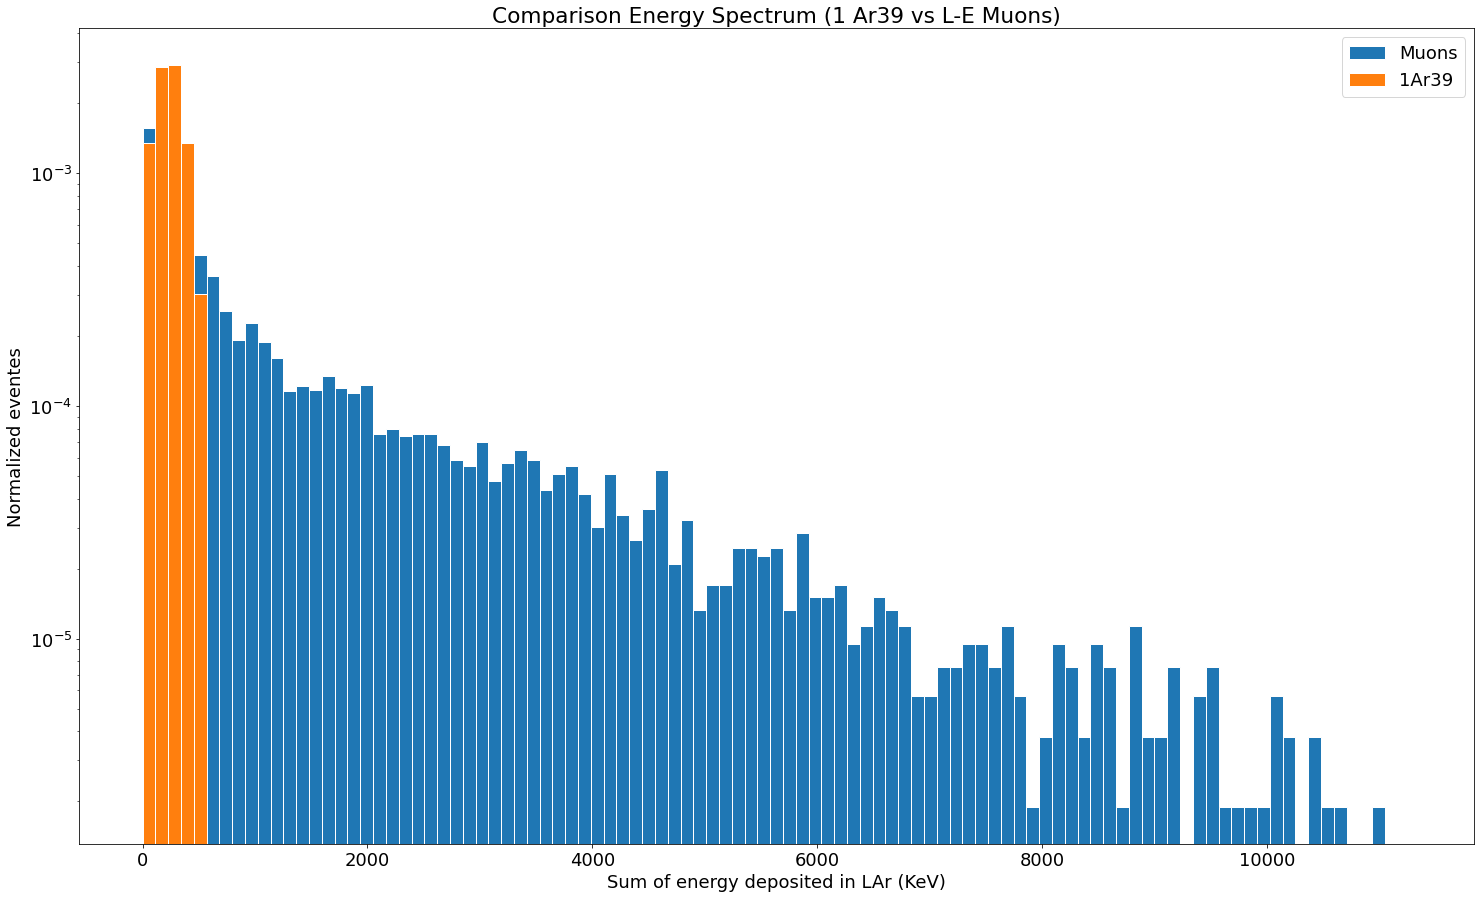

In [24]:
bins = np.linspace(0, 11279, 100)
plt.hist(muons.energydeposition, bins=bins, density=True, label="Muons", edgecolor='w')
plt.hist(dfKar39.energydeposition, bins=bins, density=True, label="1Ar39", edgecolor='w')
plt.title("Comparison Energy Spectrum (1 Ar39 vs L-E Muons)")
plt.xlabel("Sum of energy deposited in LAr (KeV)")
plt.ylabel("Normalized eventes")
plt.yscale("log")
plt.legend()
plt.show()

However, considering where the deposition occurs, the resulting PE spectrum is rather different.

The reason is that Ar39 occurs randomly in the sensitive region.
Conversly, the marginal muons could cross the sensitive volume *marginally* and then be subject to a weaker detection.

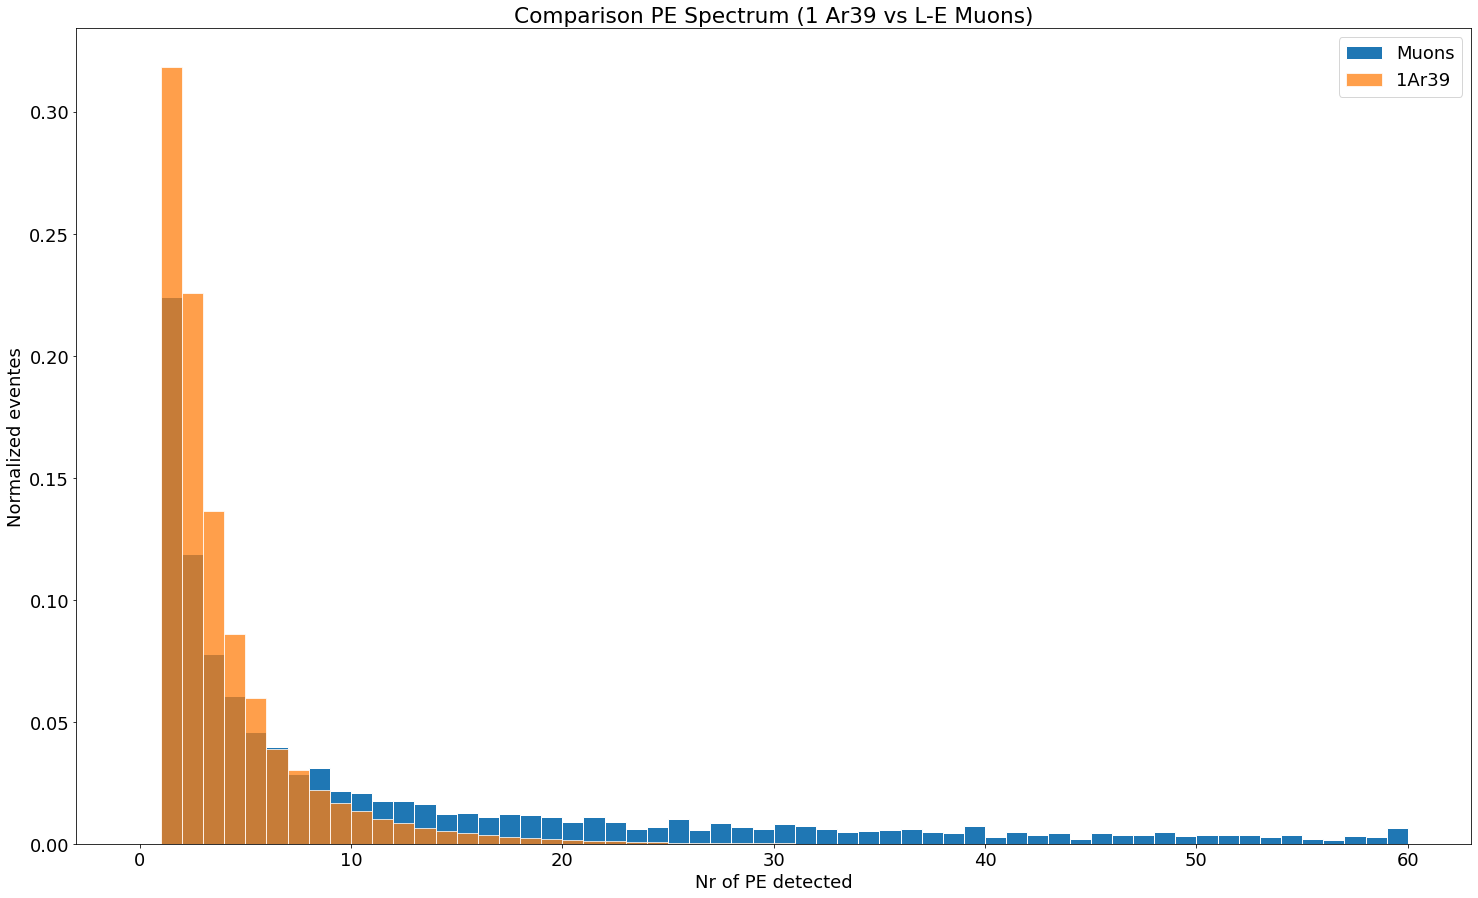

In [128]:
bins = np.linspace(0, 60, 61)
plt.hist(muons.pedetected, bins=bins, density=True, label="Muons", edgecolor='w')
plt.hist(dfKar39.pedetected, bins=bins, density=True, label="1Ar39", edgecolor='w', alpha=0.75)
plt.title("Comparison PE Spectrum (1 Ar39 vs L-E Muons)")
plt.xlabel("Nr of PE detected")
plt.ylabel("Normalized eventes")
#plt.yscale("log")
plt.legend()
plt.show()

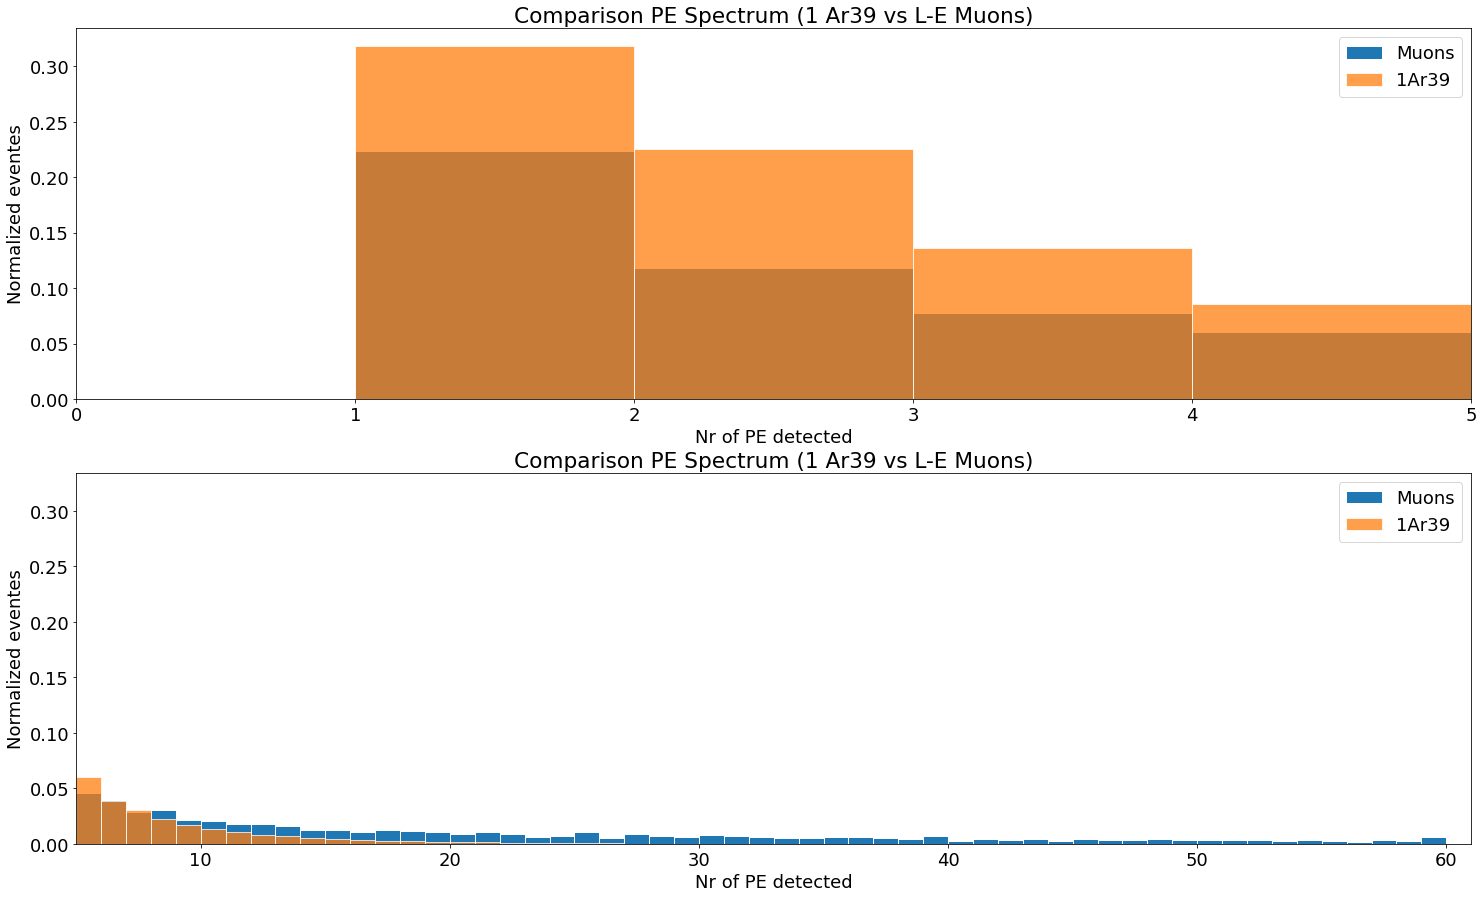

In [214]:
plt.subplot(2, 1, 1)
bins = np.linspace(0, 60, 61)
plt.hist(muons.pedetected, bins=bins, density=True, label="Muons", edgecolor='w')
plt.hist(dfKar39.pedetected, bins=bins, density=True, label="1Ar39", edgecolor='w', alpha=0.75)
plt.title("Comparison PE Spectrum (1 Ar39 vs L-E Muons)")
plt.xlabel("Nr of PE detected")
plt.ylabel("Normalized eventes")
plt.xlim(0, 5)
#plt.yscale("log")
plt.legend()

plt.subplot(2, 1, 2)
plt.hist(muons.pedetected, bins=bins, density=True, label="Muons", edgecolor='w')
plt.hist(dfKar39.pedetected, bins=bins, density=True, label="1Ar39", edgecolor='w', alpha=0.75)
plt.title("Comparison PE Spectrum (1 Ar39 vs L-E Muons)")
plt.xlabel("Nr of PE detected")
plt.ylabel("Normalized eventes")
#plt.yscale("log")
plt.xlim(5, 61)
plt.legend()
plt.show()

**Conclusion**: the Ar39 energy deposit ranges in `[0, 564] KeV` and result in a detection up to `60` PE. Conversely, the low-energy muons deposit a larger amount of energy up to `11 MeV`. However, since their marginality, the resulting PE detection is small (`<=60PE`).

# Data selection (Undersampling of Ar39)
We have different distribution and a lot of Ar39 events. We should select Ar39 events to balance the dataset for the learning. We should select about `4500` events for each class.

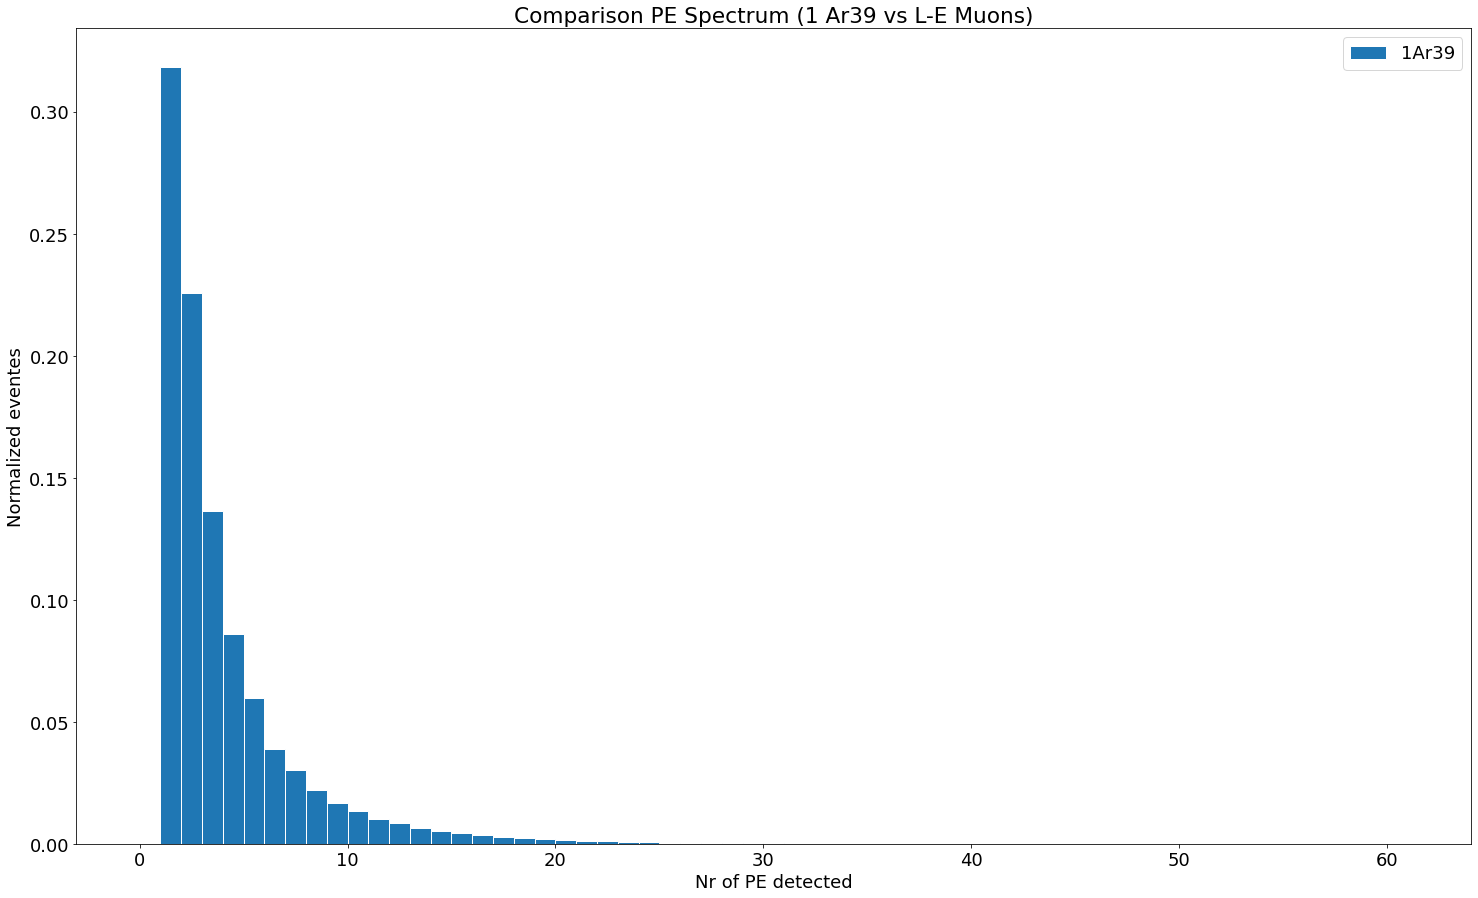

In [260]:
bins = np.linspace(0, 61, 62)
bin_cont, bin_edges, _ = plt.hist(dfKar39.pedetected, bins=bins, density=True, label="1Ar39", edgecolor='w')
x, y = bin_edges[:-1], bin_cont
# title and others
plt.title("Comparison PE Spectrum (1 Ar39 vs L-E Muons)")
plt.xlabel("Nr of PE detected")
plt.ylabel("Normalized eventes")
plt.legend()
plt.show()

In [272]:
# continue here!
avail_instances_per_pe = np.array([len(dfKar39[dfKar39.pedetected==pe])for pe in range(61)])
print(np.sum(bin_cont*4500*np.diff(bin_edges)))
nr_ar_samples_per_pe = np.array(np.where(np.ceil(bin_cont*4500)<=avail_instances_per_pe, np.ceil(bin_cont*4500), 0), dtype=int)

4500.0


In [284]:
scaled_ar39 = pd.DataFrame()
augment_from = 20
for pe in range(1, 61):
    if pe < augment_from:
        nr_instances = nr_ar_samples_per_pe[pe]
    else:
        nr_instances = 10
    scaled_ar39 = pd.concat([scaled_ar39, dfKar39[dfKar39.pedetected==pe].iloc[:nr_instances]])

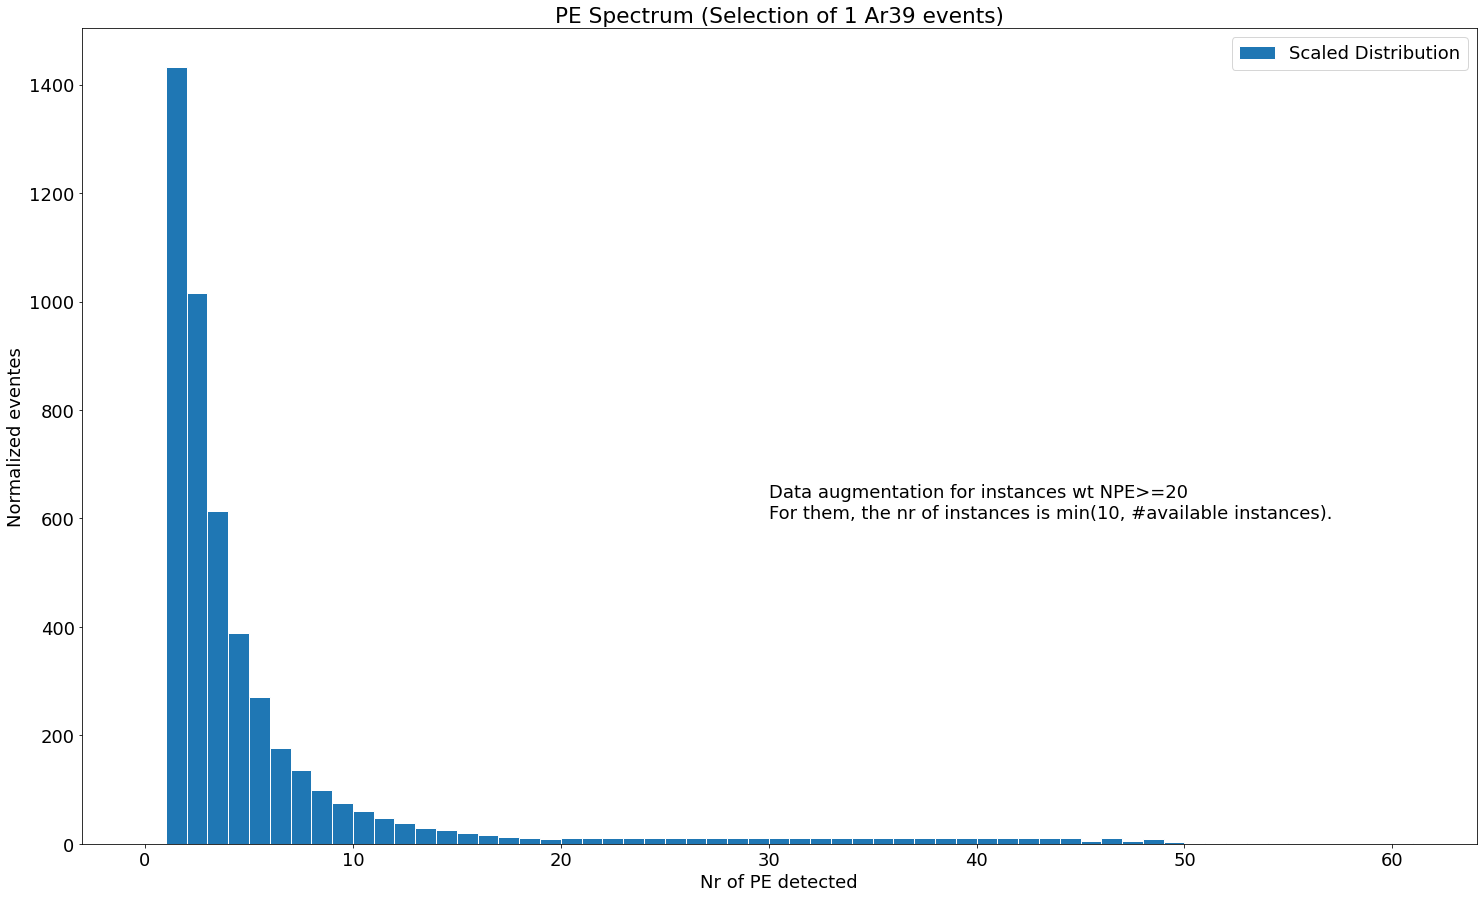

In [288]:
plt.hist(scaled_ar39.pedetected, bins=np.linspace(0, 61, 62), edgecolor='w', label="Scaled Distribution")
plt.title("PE Spectrum (Selection of 1 Ar39 events)")
plt.xlabel("Nr of PE detected")
plt.ylabel("Normalized eventes")
plt.text(30, 600, "Data augmentation for instances wt NPE>=20\n" \
                  "For them, the nr of instances is min(10, #available instances).")
plt.legend()
plt.show()

# Training wt ML
Having balanced the data, with a soft injection of high-PE instances for Ar39, we can try to train a simple model on quadrant features.

In [290]:
def stddev_idslices_fun(row):
    # given an array of aquisitions, it return the std of activated slices
    # it create a populaion of slice ids, and compute stddev on them
    id_population = [item for id_list in [[i] * int(row[i]) for i in range(len(row))] for item in id_list]
    if id_population:    # check if the list of slice ids is not empty
        return np.std(id_population)
    else:
        return -1
def stddev_idslices_fun_nonzero_assumption(row):
    # given an array of aquisitions, it return the std of activated slices
    # it create a populaion of slice ids, and compute stddev on them
    id_population = [item for id_list in [[i] * int(row[i]) for i in range(len(row))] for item in id_list]
    return np.std(id_population)

In [299]:
def produce_quadrant_features(df, nshiftings=4):
    # split aquisitions in K "shifted" quadrant
    nslices = 72
    quadrant_width = nslices // 2   # idea: spread is within 30 slices (it depends on the sampling trick)
    shift = nslices // nshiftings   # derived
    df = df.iloc[:, 2:nslices+2]   # skip the first two fields (edep, pedetected)
    # create quadrants
    df_quadrants = []
    for i_shift in range(nshiftings):
        assert(i_shift*shift < nslices)
        quadrant = df.iloc[:, i_shift*shift:i_shift*shift + quadrant_width]
        if i_shift*shift + quadrant_width >= nslices:
            quadrant = pd.concat([quadrant, df.iloc[:, :i_shift*shift + quadrant_width - nslices]], axis=1)
        df_quadrants.append(quadrant)
    # compute stddev and meanPE for each quadrant
    for quadrant in df_quadrants:
        quadrant["stdslices"] = quadrant.apply(stddev_idslices_fun, axis=1)
        quadrant["meanpe"] = quadrant.apply(lambda row: row[:36].mean(), axis=1)
    # aggregate the features in a single dataset
    features = pd.DataFrame()
    for i, quadrant in enumerate(df_quadrants):
        features = pd.concat([features, quadrant[["stdslices", "meanpe"]]], axis=1)
    features.columns = ["{}_{}".format(col, j) for j in range(len(df_quadrants)) for col in ["stdslices", "meanpe"]]
    return features

In [300]:
# Feature engineering
muon_features = produce_quadrant_features(muons)
print("[Info] Computed features for muons")
ar39_1_features = produce_quadrant_features(scaled_ar39)
print("[Info] Computed features for 1 Ar39")

/home/luigi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/luigi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[Info] Computed features for muons
[Info] Computed features for 1 Ar39


In [319]:
ar_range = np.arange(len(ar39_1_features))


[   0    1    2 ... 4765 4766 4767]
[3726 2302 2805 ... 1264 1295 1531]


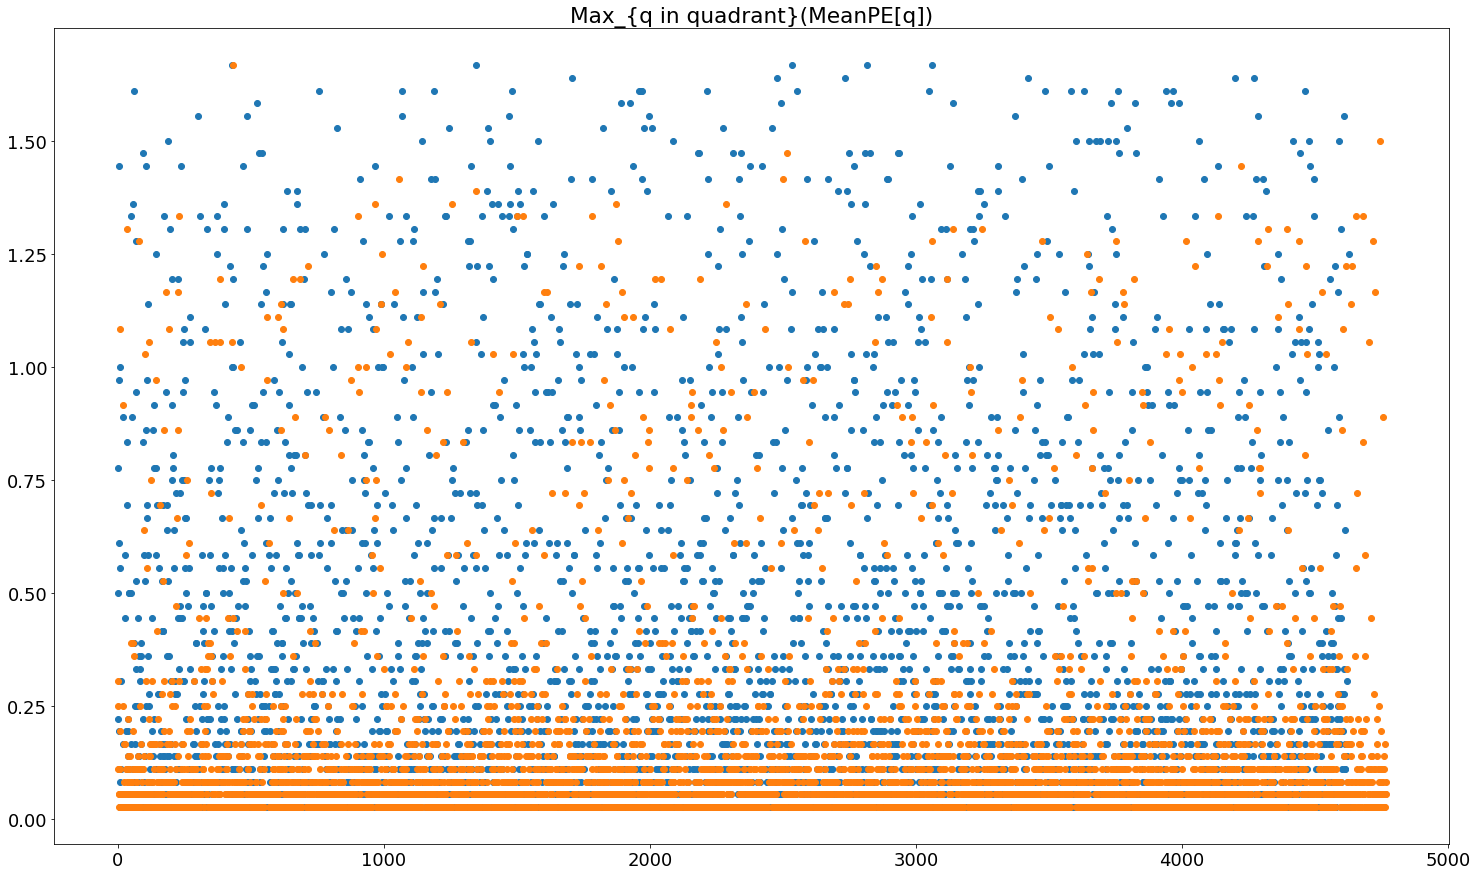

In [325]:
plt.scatter(np.arange(len(muon_features)), np.max([muon_features.meanpe_0, muon_features.meanpe_1, muon_features.meanpe_2, muon_features.meanpe_3], axis=0), label="Mu")
ar_range = np.arange(len(ar39_1_features))
np.random.shuffle(ar_range)
plt.scatter(ar_range, np.max([ar39_1_features.meanpe_0, ar39_1_features.meanpe_1, ar39_1_features.meanpe_2, ar39_1_features.meanpe_3], axis=0), label="Ar")
plt.title("Max_{q in quadrant}(MeanPE[q])")
plt.show()

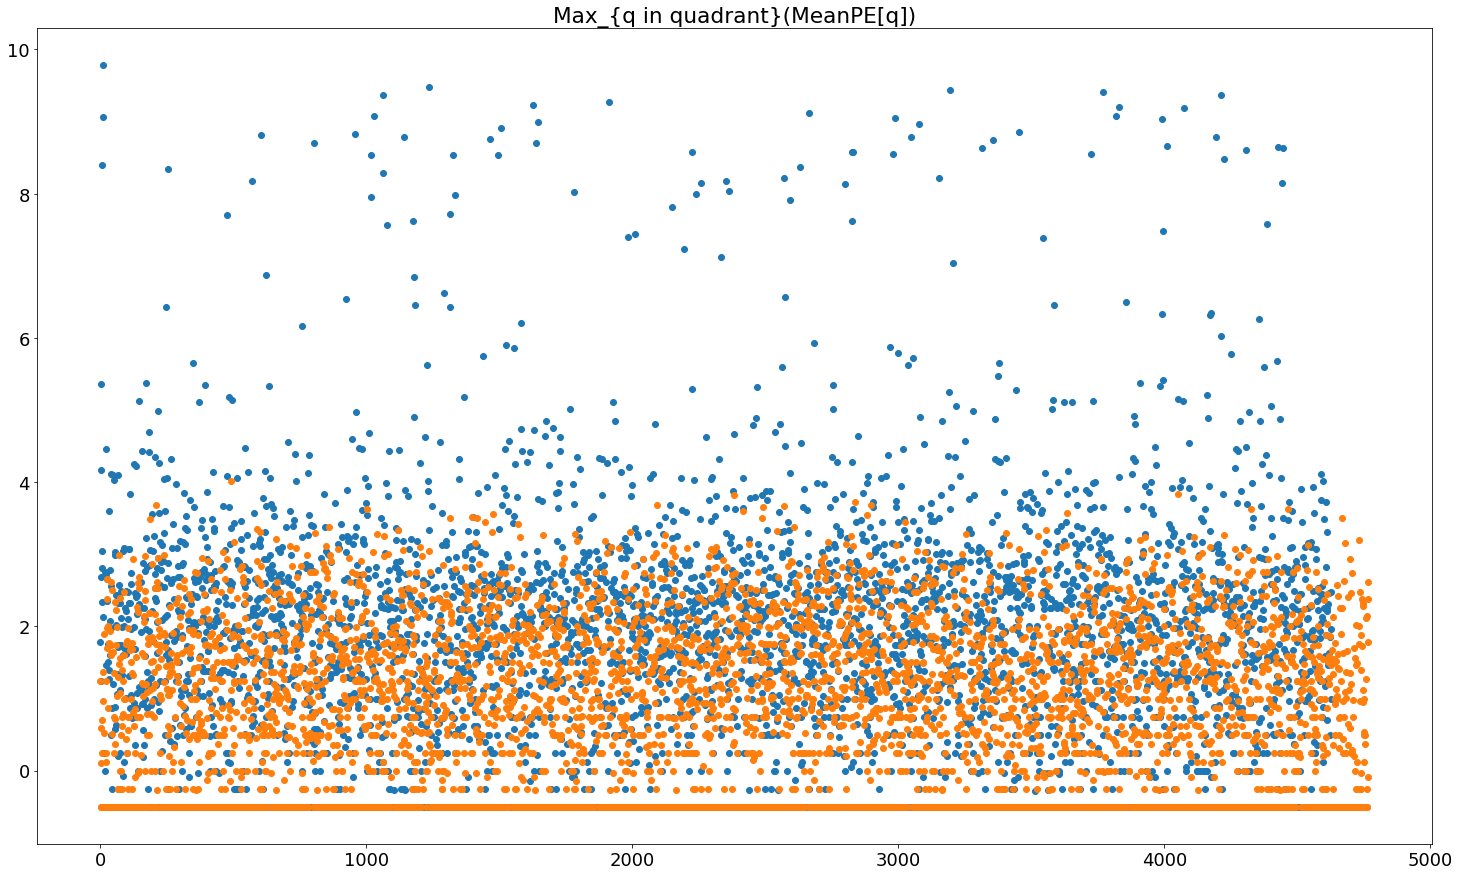

In [328]:
plt.scatter(np.arange(len(muon_features)), np.mean([muon_features.stdslices_0, muon_features.stdslices_1, muon_features.stdslices_2, muon_features.stdslices_3], axis=0), label="Mu")
ar_range = np.arange(len(ar39_1_features))
np.random.shuffle(ar_range)
plt.scatter(ar_range, np.mean([ar39_1_features.stdslices_0, ar39_1_features.stdslices_1, ar39_1_features.stdslices_2, ar39_1_features.stdslices_3], axis=0), label="Ar")
plt.title("Max_{q in quadrant}(MeanPE[q])")
plt.show()

In [333]:
from sklearn.linear_model import LogisticRegression
import sklearn.model_selection as model_selection
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, plot_roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve
from sklearn.preprocessing import StandardScaler
# models
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix

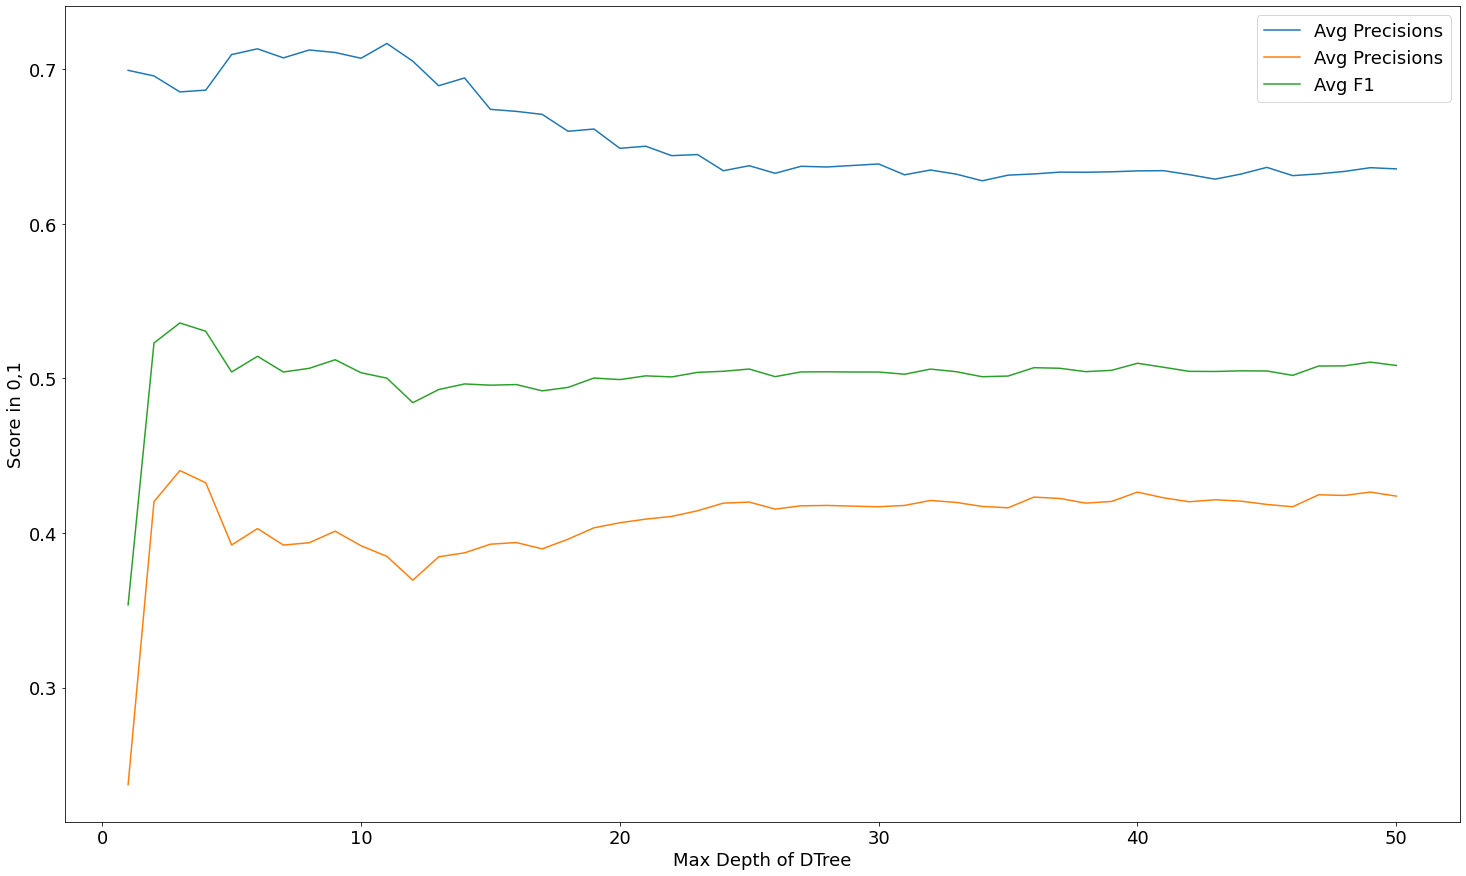

In [344]:
import time

# Prepare data for training
muon_features["y"] = 1
ar39_1_features["y"] = 0

# data preparation
data = pd.concat([muon_features, ar39_1_features], axis=0)
X, y = data.iloc[:, :-1], data.iloc[:, -1]
X = np.array(X)
y = np.array(y)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, train_size=.90)

# K-Fold X-validation
n_folds = 4    # each time 75% training, 25% validation
kf = KFold(n_splits=n_folds, shuffle=True, random_state=0)

model_template   = "[Info] Model: {}, Hyperparams: {}"
result_template  = "\t[Result] Iteration: {}: Accuracy: {:.3f}, Precision: {:.3f}, Recall: {:.3f}"
max_depth_param_list = np.linspace(1, 50, 50)
avg_precisions = []
avg_recalls = []
avg_f1 = []
for max_depth in max_depth_param_list:
    clf = DecisionTreeClassifier(max_depth=max_depth)
    #print(model_template.format("DTree", max_depth))
    start = time.time()
    # iterate over folds
    accuracies, precisions, recalls, f1s= [], [], [], []
    iteration = 0
    for train_ids, test_ids in kf.split(X):
        iteration = iteration + 1
        X_train, X_test = X[train_ids], X[test_ids]
        y_train, y_test = y[train_ids], y[test_ids]
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        accuracies.append(accuracy_score(y_test, y_pred))
        precisions.append(precision_score(y_test, y_pred))
        recalls.append(recall_score(y_test, y_pred))
        f1s.append(f1_score(y_test, y_pred))
        #print(result_template.format(iteration, accuracies[-1], precisions[-1], recalls[-1]))
    #print(result_template.format("AVG", np.mean(accuracies), np.mean(precisions), np.mean(recalls)))
    avg_precisions.append(np.mean(precisions))
    avg_recalls.append(np.mean(recalls))
    avg_f1.append(np.mean(f1s))
plt.plot(max_depth_param_list, avg_precisions, label="Avg Precisions")
plt.plot(max_depth_param_list, avg_recalls, label="Avg Precisions")
plt.plot(max_depth_param_list, avg_f1, label="Avg F1")
plt.legend()
plt.xlabel("Max Depth of DTree")
plt.ylabel("Score in 0,1")
plt.show()

In [ ]:
# define DTree model
names = ["DTree_{}Ar39".format(i+1) for i in range(0, 8, 2)]
dtree_maxdepth = 5
classifiers = [DecisionTreeClassifier(max_depth=dtree_maxdepth), DecisionTreeClassifier(max_depth=dtree_maxdepth), 
               DecisionTreeClassifier(max_depth=dtree_maxdepth), DecisionTreeClassifier(max_depth=dtree_maxdepth), 
               DecisionTreeClassifier(max_depth=dtree_maxdepth)]

# Data augmentation (Oversampling Muons)
Increase the number of muons instances. 

**Pro**: we get a larger amount of muon training data. 

**Cons**: this could lead to overfitting of training data.

In [209]:
muons.head()

,energydeposition,pedetected,slice0,slice1,slice2,slice3,slice4,slice5,slice6,slice7,...,slice62,slice63,slice64,slice65,slice66,slice67,slice68,slice69,slice70,slice71
0,2053.560,18,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4645.520,28,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1484.800,8,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,960.528,9,1,0,0,0,1,0,0,0,...,0,0,0,1,0,1,0,0,0,0
4,8843.430,59,0,0,0,0,0,0,0,0,...,0,0,1,1,1,0,0,0,0,0


(array([6.98123932e-01, 0.00000000e+00, 4.21349950e-01, 0.00000000e+00,
        2.66043447e-01, 0.00000000e+00, 1.84948797e-01, 0.00000000e+00,
        1.20314627e-01, 0.00000000e+00, 9.39073749e-02, 0.00000000e+00,
        6.85024954e-02, 0.00000000e+00, 5.13435408e-02, 0.00000000e+00,
        4.11428666e-02, 0.00000000e+00, 3.16612538e-02, 0.00000000e+00,
        0.00000000e+00, 2.57298541e-02, 0.00000000e+00, 2.06013329e-02,
        0.00000000e+00, 1.67026177e-02, 0.00000000e+00, 1.35376687e-02,
        0.00000000e+00, 1.09785547e-02, 0.00000000e+00, 8.92528363e-03,
        0.00000000e+00, 7.12983556e-03, 0.00000000e+00, 5.78533268e-03,
        0.00000000e+00, 4.57856414e-03, 0.00000000e+00, 0.00000000e+00,
        3.66490997e-03, 0.00000000e+00, 2.99486424e-03, 0.00000000e+00,
        2.31697599e-03, 0.00000000e+00, 1.87338316e-03, 0.00000000e+00,
        1.43420176e-03, 0.00000000e+00, 1.12932360e-03, 0.00000000e+00,
        8.33268284e-04, 0.00000000e+00, 6.69065416e-04, 0.000000

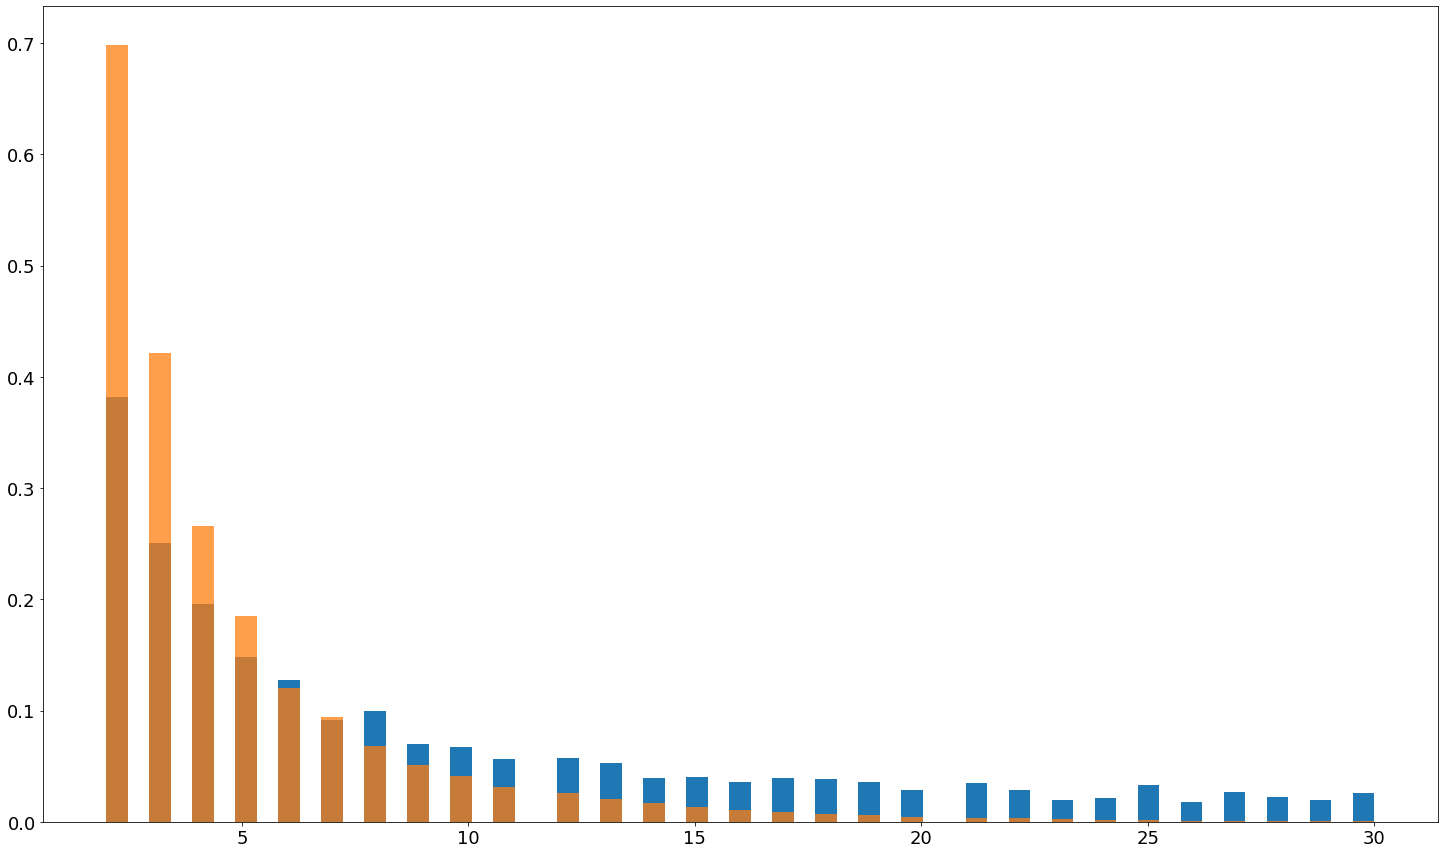

In [205]:
plt.hist(muons[(muons.pedetected>1) & (muons.pedetected<31)].pedetected, bins=59, density=True)
plt.hist(dfKar39[(dfKar39.pedetected>1) & (dfKar39.pedetected<31)].pedetected, bins=59, density=True, alpha=0.75)

In [162]:
np.where(norm_bin_content>0, np.log(norm_bin_content), 0)

/home/luigi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


array([ 0.00000000e+00,  1.45124819e+01,  1.41691798e+01,  1.36642469e+01,
        1.32044428e+01,  1.28408622e+01,  1.24108934e+01,  1.21630921e+01,
        1.18476533e+01,  1.15593223e+01,  1.13378337e+01,  1.10758768e+01,
        1.08684351e+01,  1.06461389e+01,  1.04363486e+01,  1.02262592e+01,
        1.00167269e+01,  9.80967126e+00,  9.58507132e+00,  9.37610901e+00,
        9.14216859e+00,  8.91958692e+00,  8.71768205e+00,  8.46104603e+00,
        8.24852912e+00,  7.98139158e+00,  7.74240202e+00,  7.43838353e+00,
        7.21890971e+00,  6.92755791e+00,  6.75227038e+00,  6.42648846e+00,
        6.14203741e+00,  5.87773578e+00,  5.57594910e+00,  5.26785816e+00,
        5.05624580e+00,  4.66343909e+00,  4.41884061e+00,  4.07753744e+00,
        3.80666249e+00,  3.46573590e+00,  3.29583687e+00,  2.77258872e+00,
        2.63905733e+00,  1.60943791e+00,  2.30258509e+00,  1.60943791e+00,
        2.19722458e+00,  1.38629436e+00,  6.93147180e-01, -4.91912067e-10,
       -4.91912067e-10,  

In [208]:
len(dfKar39[dfKar39.pedetected>30])/len(dfKar39)*100

0.03927692418887921